In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import glob
from shapely.geometry import Polygon, LineString, Point
import pickle
plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib import cm
from matplotlib.colors import ListedColormap
tab20 = cm.get_cmap('tab20',20)
tab9  = ListedColormap(tab20(np.linspace(0,8/19,9)))

# Constants and definitions

In [2]:
def get_impact_threshold(d,g,rho_f,rho_s,thresholdconstant): #bagnold 1941, p 86, eqn I
    return thresholdconstant*((rho_s-rho_f)/rho_f*g*d)**0.5

In [3]:
# rub' al khali
lonlims = [49.0-0.1,56.3-0.1]
latlims = [18.0-0.1,23.2-0.1]

# constants

d     = 300e-6
z     = 10
g     = 9.8
z0    = 1e-3
rho_s = 2650
rho_f = 1.2
kappa = 0.4
phi = 0.6

fluxconstant      = 5
thresholdconstant = 0.082

usimth = get_impact_threshold(d,g,rho_f,rho_s,thresholdconstant)

r = 6371.229*1e+3 #https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Spatialreferencesystems

In [4]:
# sort the mass balance:
# want an equivalent thickness field
# want a land fraction field too
# want to make sure erosion can't occur where there is no sand
# have to start with a thickness field, then add the dthickness each timestep to make sure of this
# qx=0 where np.cos(qa)*qm if eta=0

# get qm and uth to not be idealized:
# soil moisture and precipitation
# z0 from topo
# z0 for vegetation

# for rub' al khali
# maps of 1) A_E area fraction of erodible surface and 2) Z_D equivalent sand thickness
# on northwest side: BC is A_E=1, Z_D=inf, southeast side: A_E=0, Z_D=0

In [5]:
dfverts=[[50.52815736, 18.46406547],
        [50.76809151, 18.49951671],
        [50.88279295, 18.48648637],
        [50.93161872, 18.37455539],
        [50.91664226, 18.31630878],
        [50.99694511, 18.31931122],
        [51.07876088, 18.41534758],
        [51.09301637, 18.51468053],
        [51.20432098, 18.58208886],
        [51.44002329, 18.61324037],
        [51.63563799, 18.64198234],
        [51.73127743, 18.62250047],
        [51.88200214, 18.62926307],
        [52.06123241, 18.65455065],
        [52.32841596, 18.70190271],
        [52.41009544, 18.74544072],
        [52.57139702, 18.71655723],
        [52.60252833, 18.65895232],
        [52.68918406, 18.67801159],
        [52.821054  , 18.67452564],
        [52.95172706, 18.64941551],
        [52.99391152, 18.51926534],
        [53.09024799, 18.49525753],
        [53.11707339, 18.45195882],
        [53.19732682, 18.42640817],
        [53.37570235, 18.42875643],
        [53.46373298, 18.47122871],
        [53.51574566, 18.49293376],
        [53.59144505, 18.52338321],
        [53.80638119, 18.67145884],
        [53.96442308, 18.74920205],
        [54.00046227, 18.82143981],
        [54.0467683 , 18.93281133],
        [54.13770064, 19.05373419],
        [54.19604263, 19.13363026],
        [54.23727649, 19.09450803],
        [54.25787276, 19.12057859],
        [54.41588108, 19.31898113],
        [54.5242389 , 19.44710742],
        [54.64824818, 19.53925769],
        [54.82072608, 19.60674499],
        [54.87589202, 19.56913016],
        [55.12528861, 19.7135664 ],
        [55.24156718, 19.80470999],
        [55.40502707, 19.84506991],
        [55.47019971, 19.72337413],
        [55.59349585, 19.79986346],
        [55.80245589, 19.97240868],
        [55.84651607, 20.08747637],
        [55.86801479, 20.26810201],
        [55.78989754, 20.37552557],
        [55.68791666, 20.41665126],
        [55.67513153, 20.53211979],
        [55.82856663, 20.69405777],
        [56.09325843, 20.76658003],
        [56.18494234, 20.86229568],
        [56.20418117, 20.9796403 ],
        [56.1269255 , 21.08131605],
        [56.04811994, 21.19200233],
        [55.9428198 , 21.26623922],
        [55.7647681 , 21.40943226],
        [55.64400056, 21.58371644],
        [55.48903245, 21.80825688],
        [55.43532666, 22.05952333],
        [55.38928625, 22.34993027],
        [55.32840464, 22.62295961],
        [55.22729697, 22.90142631],
        [55.07808791, 22.94229528],
        [54.9630966 , 22.93358437],
        [54.91318445, 22.80513326],
        [54.80552439, 22.7402138 ],
        [54.64740109, 22.75385627],
        [54.48454873, 22.82582428],
        [54.28525733, 22.92644977],
        [54.13862743, 23.01165366],
        [53.94989773, 23.10656844],
        [53.72976046, 23.11682675],
        [53.55030346, 23.06562733],
        [53.4380368 , 22.9769386 ],
        [53.45920572, 22.8618176 ],
        [53.53436195, 22.80190802],
        [53.59387321, 22.72559359],
        [53.61827252, 22.57916425],
        [53.685039  , 22.43226769],
        [53.6470913 , 22.33915233],
        [53.60876035, 22.10503822],
        [53.65627508, 21.90404738],
        [53.6560879 , 21.72177774],
        [53.55231308, 21.17814873],
        [53.48659065, 20.91994193],
        [53.45141579, 20.67573154],
        [53.38253023, 20.51722127],
        [53.3520789 , 20.3267098 ],
        [53.34481044, 20.21723698],
        [53.21215814, 20.10673068],
        [53.04413946, 20.00082051],
        [52.79181145, 19.7652275 ],
        [52.37938496, 19.42627677],
        [52.09339705, 19.24670552],
        [51.65018795, 19.07765693],
        [51.33240101, 19.01298624],
        [51.12993198, 18.94200714],
        [50.82280156, 18.88338642],
        [50.62806846, 18.82882316],
        [50.36793512, 18.75931586],
        [50.18610602, 18.69293169],
        [49.83211592, 18.50569423],
        [49.50598367, 18.38443099],
        [49.10219518, 18.12364326],
        [49.08304078, 18.04908759],
        [49.54300391, 18.17045819],
        [50.22051122, 18.34745439],
        [50.52815736, 18.46406547]]

dfpoly = Polygon(np.asarray(dfverts))

In [5]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
n = 0
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid0,templatgrid0,thetas0,
    areafraction0,bedrockele0,equivalentthickness0,
    fulllengthfractiontheta0,lengthweightedslopetheta0,bedformlengththeta0) = pickle.load(f)
n = 1
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid1,templatgrid1,thetas1,
    areafraction1,bedrockele1,equivalentthickness1,
    fulllengthfractiontheta1,lengthweightedslopetheta1,bedformlengththeta1) = pickle.load(f)
    
templongrid = np.hstack((templongrid0,templongrid1))
templatgrid = templatgrid0
thetas = thetas0
areafraction = np.hstack((areafraction0,areafraction1))
bedrockele = np.hstack((bedrockele0,bedrockele1))
equivalentthickness = np.hstack((equivalentthickness0,equivalentthickness1))
fulllengthfractiontheta = np.hstack((fulllengthfractiontheta0,fulllengthfractiontheta1))
lengthweightedslopetheta = np.hstack((lengthweightedslopetheta0,lengthweightedslopetheta1))
bedformlengththeta = np.hstack((bedformlengththeta0,bedformlengththeta1))

dlon = 0.1
dlat = 0.1

# convert the slope from eta/deg to eta/distance
r = 6371.229*1e+3
tlon = np.linspace(templongrid[0]-dlon/2,templongrid[-1]+dlon/2,len(templongrid)+1)
tlat = np.linspace(templatgrid[0]-dlat/2,templatgrid[-1]+dlat/2,len(templatgrid)+1)
Lon,Lat = np.meshgrid(tlon,tlat)
Ly = (r*np.diff(Lat*np.pi/180,axis=0))[:,1:]
Lx = (r*np.diff(Lon*np.pi/180,axis=1)*np.sin(np.pi/2-Lat[:,1:]*np.pi/180))[1:]
Ls = (Lx*Ly)**0.5
lengthweightedslopetheta = lengthweightedslopetheta*(dlon/Ls[:,:,np.newaxis])
fulllengththeta = fulllengthfractiontheta*Ls[:,:,np.newaxis]
bedrockele = bedrockele*equivalentthickness/equivalentthickness
bedformlengththeta = bedformlengththeta*(Ls[:,:,np.newaxis]/dlon)
beta = 1/np.nanmean(lengthweightedslopetheta)
mask = areafraction/areafraction

/local/k10/ag5517/tmp/ipykernel_334143/1148961769.py:36: RuntimeWarning: invalid value encountered in multiply
  bedrockele = bedrockele*equivalentthickness/equivalentthickness


In [4]:
lonOI = 54.0
latOI = 22.7
lonOIind = 50
latOIind = 47

# Generation

In [6]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
n = 0
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid0,templatgrid0,thetas0,
    areafraction0,bedrockele0,equivalentthickness0,
    fulllengthfractiontheta0,lengthweightedslopetheta0,bedformlengththeta0) = pickle.load(f)
n = 1
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid1,templatgrid1,thetas1,
    areafraction1,bedrockele1,equivalentthickness1,
    fulllengthfractiontheta1,lengthweightedslopetheta1,bedformlengththeta1) = pickle.load(f)

templongrid = np.hstack((templongrid0,templongrid1))
templatgrid = templatgrid0
thetas = thetas0
areafraction = np.hstack((areafraction0,areafraction1))
bedrockele = np.hstack((bedrockele0,bedrockele1))
equivalentthickness = np.hstack((equivalentthickness0,equivalentthickness1))
fulllengthfractiontheta = np.hstack((fulllengthfractiontheta0,fulllengthfractiontheta1))
lengthweightedslopetheta = np.hstack((lengthweightedslopetheta0,lengthweightedslopetheta1))
bedformlengththeta = np.hstack((bedformlengththeta0,bedformlengththeta1))

dlon = 0.1
dlat = 0.1

# convert the slope from eta/deg to eta/distance
r = 6371.229*1e+3
tlon = np.linspace(templongrid[0]-dlon/2,templongrid[-1]+dlon/2,len(templongrid)+1)
tlat = np.linspace(templatgrid[0]-dlat/2,templatgrid[-1]+dlat/2,len(templatgrid)+1)
Lon,Lat = np.meshgrid(tlon,tlat)
Ly = (r*np.diff(Lat*np.pi/180,axis=0))[:,1:]
Lx = (r*np.diff(Lon*np.pi/180,axis=1)*np.sin(np.pi/2-Lat[:,1:]*np.pi/180))[1:]
Ls = (Lx*Ly)**0.5
lengthweightedslopetheta = lengthweightedslopetheta*(dlon/Ls[:,:,np.newaxis])
fulllengththeta = fulllengthfractiontheta*Ls[:,:,np.newaxis]
bedrockele = bedrockele*equivalentthickness/equivalentthickness
bedformlengththeta = bedformlengththeta*(Ls[:,:,np.newaxis]/dlon)
beta = 1/np.nanmean(lengthweightedslopetheta)
mask = areafraction/areafraction

/local/k10/ag5517/tmp/ipykernel_1473326/1811226495.py:36: RuntimeWarning: invalid value encountered in multiply
  bedrockele = bedrockele*equivalentthickness/equivalentthickness


In [38]:
years  = np.arange(1981,2020+1)
months = np.arange(1,12+1)

for i in range(len(years)):
    for j in range(len(months)):
        era5  = xr.open_dataset(glob.glob('/g/data/zz93/era5-land/reanalysis/u10/%d/u10_era5-land_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5v = xr.open_dataset(glob.glob('/g/data/zz93/era5-land/reanalysis/v10/%d/v10_era5-land_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5  = era5.merge(era5v)            
        era5  = era5.sel(longitude=lonOI,latitude=latOI)
        era5 = era5.assign(qm=(((era5.u10**2+era5.v10**2)*(kappa/np.log(z/z0))**2-usimth**2)*fluxconstant*usimth/g*rho_f).where(((era5.u10**2+era5.v10**2)**0.5*(kappa/np.log(z/z0)))>usimth,0))
        era5 = era5.assign(qa=(np.arctan2(era5.v10,era5.u10)))
        
        qa = np.asarray(era5.qa)
        qm = np.asarray(era5.qm)
        
        # slopes
        
        tempdirargs = np.argmin(np.abs(thetas[np.newaxis,:]-qa[:,np.newaxis]),axis=1)
        l = np.indices(tempdirargs.shape)

        tempslopes = np.repeat(lengthweightedslopetheta[lonOIind,latOIind][np.newaxis,:], len(era5.time), axis=0)
        windfacingslope = tempslopes[l,tempdirargs]
        
        templengthfrac = np.repeat(fulllengthfractiontheta[lonOIind,latOIind][np.newaxis,:], len(era5.time), axis=0)
        winddirlengthfrac = templengthfrac[l,tempdirargs]
        
        if (i==0)&(j==0):
            qm_store = qm*winddirlengthfrac*(1+beta*windfacingslope)/2
        else:
            qm_store = np.hstack((qm_store,qm*winddirlengthfrac*(1+beta*windfacingslope)/2))
        
        print('year %d, month %d'%(years[i],months[j]),end='\r')
        
with open(directory+'era5land-qm-%.1flon%.1flat.pkl'%(lonOI,latOI), 'wb') as f:
    pickle.dump(qm_store, f)

# Load

In [7]:
with open(directory+'era5land-qm-%.1flon%.1flat.pkl'%(lonOI,latOI), 'rb') as f:
    qm_store = pickle.load(f)
qm_store = np.ndarray.flatten(qm_store)

# Analysis

In [8]:
nbins = 200
qmbins = np.linspace(0,0.03,nbins)
qmbinmids = qmbins[1:]-np.diff(qmbins)[0]/2
qmpdf,_ = np.histogram(qm_store,bins=qmbins,density=True)

fitind0 = np.argwhere(qmbins>0.006)[0][0]
polyfit = np.polyfit(qmbinmids[fitind0:][qmpdf[fitind0:]>0],np.log(qmpdf[fitind0:][qmpdf[fitind0:]>0]),1)
Apolyfit = np.exp(polyfit[1])
Bpolyfit = polyfit[0]

Text(0, 0.5, 'PDF')

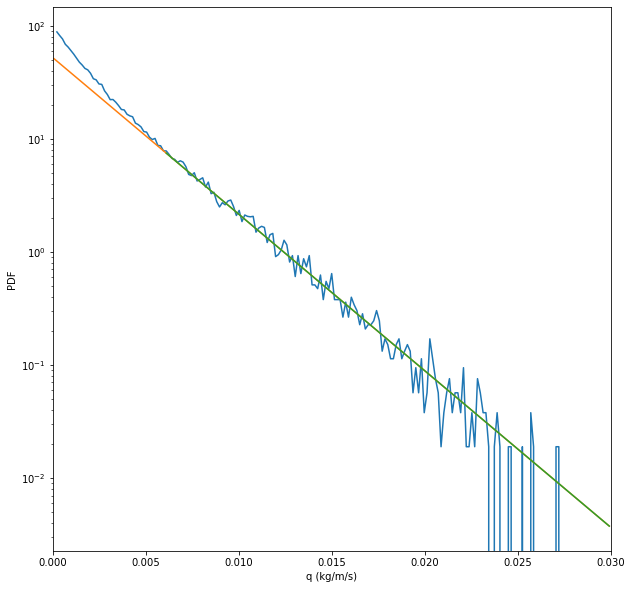

In [9]:
plt.plot(qmbinmids[1:],qmpdf[1:])
plt.plot(qmbinmids,Apolyfit*np.exp(Bpolyfit*qmbinmids))
plt.plot(qmbinmids[fitind0:],Apolyfit*np.exp(Bpolyfit*qmbinmids[fitind0:]))
plt.yscale('log')
plt.xlim(qmbins[0],qmbins[-1])
plt.xlabel('q (kg/m/s)')
plt.ylabel('PDF')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'autocorrelation')

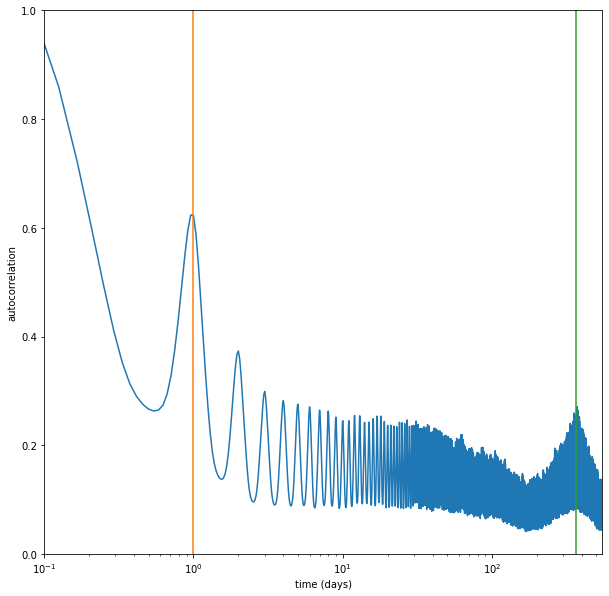

In [41]:
plt.plot(time/60/60/24,c_fourier)
plt.plot([1,1],[0,1])
plt.plot([365,365],[0,1])
plt.xscale('log')
plt.xlim(1e-1,365*1.5)
plt.ylim(0,1)
plt.xlabel('time (days)')
plt.ylabel('autocorrelation')